In [32]:
import pandas as pd
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import  cross_val_score, StratifiedKFold, GridSearchCV



In [33]:
df = pd.read_csv('../data/raw/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [34]:
# scale the columns 'Time' and 'Amount'
rs = RobustScaler()

df['scaled_amount'] = rs.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rs.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time', 'Amount'], axis=1, inplace=True)
print(df.head())
# print(df)


# Oversampling the minority class using SMOTE technique
X = df.drop('Class', axis=1)
y = df['Class']
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
df_resampled = X_resampled.copy()
df_resampled['Class'] = y_resampled
print("Original dataset shape:", df['Class'].value_counts())
print("Resampled dataset shape:", df_resampled['Class'].value_counts())

         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V22       V23       V24       V25  \
0  0.098698  0.363787  0.090794  ...  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425 -0.166974  ... -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  0.207643  ...  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024 -0.054952  ...  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  0.753074  ...  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Class  scaled_amount  scaled_time  

In [35]:
# spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")

Training set shape: (227845, 30), Testing set shape: (56962, 30)


In [36]:
# Random Forest model for prediction
model = RandomForestClassifier(n_estimators=50, random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(predictions)

[0 0 0 ... 0 0 0]


In [37]:
y_prob = model.predict_proba(X_test)[:, 1]

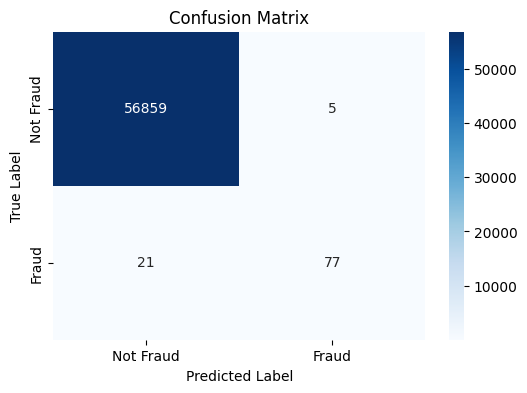

In [38]:
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


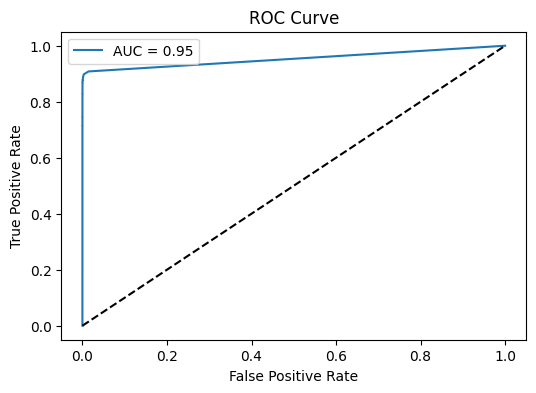

In [39]:
# ROC Curve & AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

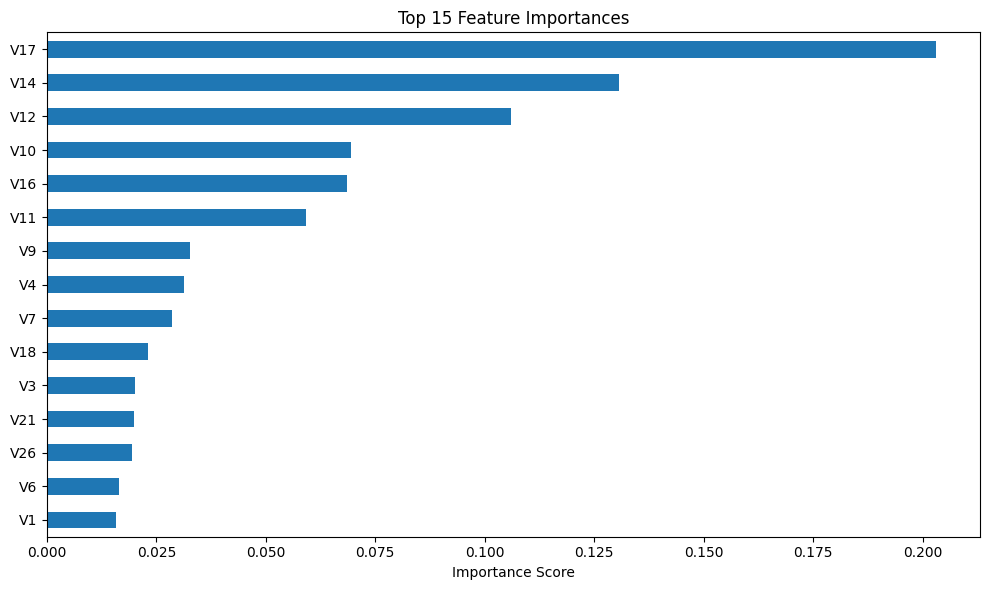

In [40]:

# Feature Importances
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feature_importances[:15].plot(kind='barh')
plt.title("Top 15 Feature Importances")
plt.gca().invert_yaxis()
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


# Hold for few days
I am not sure what's going on with the above code. Or, what I did till know, So I will take break for few days to understand the code and learn more. 